# 사용할 패키지

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob # 폴더 안에 파일들의 목록을 불러올 때 사용
from tqdm import tqdm # for문의 상태바를 나타내주는 tqdm라이브러리

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv3D, ConvLSTM2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# TPU 장치 설정

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On kaggle this is always the case.
    print('Running on TPU', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
print("Replicas: ", strategy.num_replicas_in_sync)

In [3]:
path = '/content/drive/MyDrive/'

# **데이터 가져오기**

In [4]:
train_csv = pd.read_csv(path+'train.csv')

In [5]:
train_csv.head()

,month,file_nm
0,1978-11,197811.npy
1,1978-12,197812.npy
2,1979-01,197901.npy
3,1979-02,197902.npy
4,1979-03,197903.npy


1988년 1월에서 2017년 12월까지 30년 데이터를 학습하였습니다.

In [ ]:
train_path = sorted(glob(path+'train/*.npy'))     # glub : 폴더 안에 파일들의 목록을 불러올 때 사용
train_path = train_path[-30*12:]
train_path

In [9]:
train = []
for p in tqdm(train_path):     # for문의 상태바를 나타내주는 tqdm라이브러리
    train.append(np.load(p))
train = np.array(train)

100%|██████████| 360/360 [00:01<00:00, 353.41it/s]


In [10]:
train.shape # 월마다 448row, 304column, 5depth의 데이터가 360개월치 존재

(360, 448, 304, 5)

# **데이터 시각화**

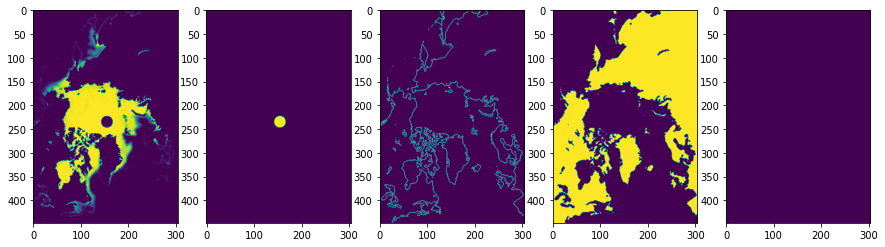

In [11]:
plt.figure(figsize=(15,10))
plt.subplot(151)               # 1행 5열의 구조. 첫번째 그래프
plt.imshow(train[0,:,:,0])
plt.subplot(152)               # 1행 5열의 구조. 두번째 그래프
plt.imshow(train[0,:,:,1])
plt.subplot(153)               # 1행 5열의 구조. 세번째 그래프
plt.imshow(train[0,:,:,2])
plt.subplot(154)               # 1행 5열의 구조. 네번째 그래프
plt.imshow(train[0,:,:,3])
plt.subplot(155)               # 1행 5열의 구조. 다섯번째 그래프
plt.imshow(train[0,:,:,4])

# **사각 메우기**

In [ ]:
missings = pd.DataFrame()

for k in range(360) : 
  missings = pd.concat([missings,pd.DataFrame(train[k,:,:,4].reshape(-1,1))],ignore_index=True)

print(missings.min().min())
print(missings.max().max())

0
0


In [12]:
train[0,:,:,0] + train[0,:,:,1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [13]:
for k in range(360) :

  new_array = train[k,:,:,0] + train[k,:,:,1]*250
  train[k,:,:,0] = new_array

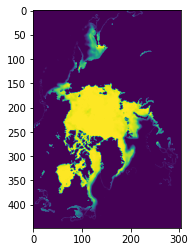

In [ ]:
plt.imshow(train[0,:,:,0])

# **월별 데이터로 분리**

In [14]:
train_month = []
for i in range(12):
    train_month.append(train[i::12, :,:])
train_month = np.array(train_month)

In [ ]:
train_month.shape

(12, 30, 448, 304, 5)

# **이미지를 잘랐을 때 사이즈가 같도록 패딩**

In [15]:
stride = 32
temp = np.zeros([train_month.shape[0],
                 train_month.shape[1],
                 train_month.shape[2]+(stride-train_month.shape[2]%stride),
                 train_month.shape[3]+(stride-train_month.shape[3]%stride),
                 train_month.shape[4]], np.uint8)
temp[:, :, :train_month.shape[2], :train_month.shape[3], :] = train_month     #이렇게 되면 480*320의 왼쪽 상단에는 패딩이 안된거 아닌가? 우측 하단 부분은 중요치 않아서 상관 없나?
train_month = temp
del temp

In [ ]:
train_month.shape

(12, 30, 480, 320, 5)

# **5년 단위로 데이터 전처리**

In [16]:
window_size = 5

In [17]:
x_train = []     # x_train = train_month[:, [0:5, 1:6,... 24:29], :, :, :] 앞에서부터 5년치씩 묶음
y_train = []     # y_train = train_month[:, [5:6, 6:7,... 29:30], :, :, :] 앞의 묶음 다음해

for i in range(train_month.shape[1]-window_size):
    x_train.append(train_month[:, i:i+window_size, :, :, :])
    y_train.append(train_month[:, i+window_size:i+window_size+1, :, :, :])

x_train = np.array(x_train)
y_train = np.array(y_train)

In [18]:
x_train.shape, y_train.shape

((25, 12, 5, 480, 320, 5), (25, 12, 1, 480, 320, 5))

# **시각화**

특정 월의 5년간 변화와 그 다음 상태

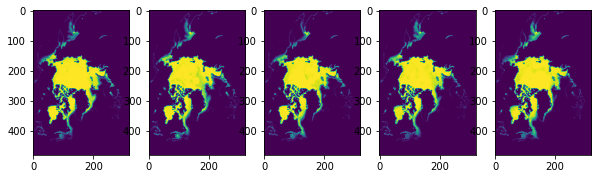

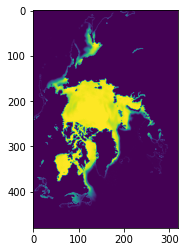

In [19]:
m = 1     # 제일 처음 5년 중 각 해의 첫 달(데이터는 11월부터 시작)과 다음 해의 같은 달 시각화  
plt.figure(figsize=(10,15))
for y in range(x_train.shape[2]):
    plt.subplot(1,window_size,y+1)
    plt.imshow(x_train[0,m-1,y,:,:,0])
plt.show()

plt.imshow(y_train[0,m-1,-1,:,:,0])

# **데이터 자르기**

이미지가 클 경우 ConvLSTM모델의 메모리가 부족하여 가로세로 32px씩 이동하며 128x128로 이미지를 잘랐습니다.

학습에는 2017년까지, 2017년도를 평가 데이터로 활용하여 학습 결과를 2017년(가장 최근년도)에 과적합시켰습니다.

In [25]:
#stride = 32
feature_size = 128

x_train_ = []
y_train_ = []

for y in range(24):
    for m in range(12):
        for i in range((x_train.shape[3]-feature_size)//stride+1):
            for j in range((x_train.shape[4]-feature_size)//stride+1):
                x_ = x_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
                y_ = y_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
                x_train_.append(x_)
                y_train_.append(y_)

x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)

x_val_ = []
y_val_ = []

for y in range(23,24):
  for m in range(12):
      for i in range((x_train.shape[3]-feature_size)//stride+1):
          for j in range((x_train.shape[4]-feature_size)//stride+1):
              x_ = x_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
              y_ = y_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
              x_val_.append(x_)
              y_val_.append(y_)
            
x_val_ = np.array(x_val_)
y_val_ = np.array(y_val_)

x_test_ = []
y_test_ = []

for y in range(24,25):
  for m in range(12):
    for i in range((x_train.shape[3]-feature_size)//stride+1):
      for j in range((x_train.shape[4]-feature_size)//stride+1):
        x_ = x_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
        y_ = y_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
        x_test_.append(x_)
        y_test_.append(y_)

x_test_ = np.array(x_test_)
y_test_ = np.array(y_test_)

In [2]:
x_train_.shape, y_train_.shape, x_val_.shape, y_val_.shape, x_test_.shape, y_test_.shape

NameError: ignored

# **데이터 시각화**

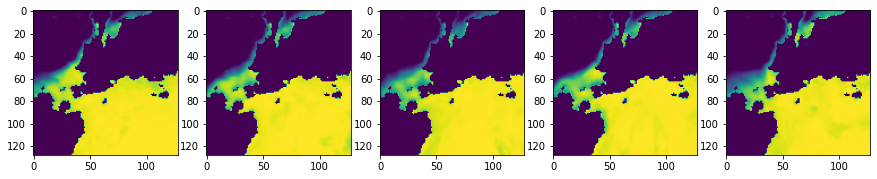

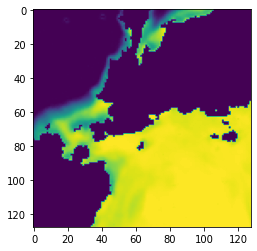

In [27]:
i = 22
plt.figure(figsize=(15,10))
for y in range(x_train_.shape[1]):
    plt.subplot(1,window_size,y+1)
    plt.imshow(x_train_[i,y,:,:,0])
plt.show()
plt.imshow(y_train_[i,-1,:,:,0])

# **데이터셋**

In [28]:
def train_map_func(x, y):
    x = tf.cast(x, tf.float32)/250
    y = tf.cast(y, tf.float32)
    return x, y

In [29]:
BATCH_SIZE = 32

In [30]:
# tf.data.Dataset.from_tensor_slices 함수는 tf.data.Dataset를 생성하는 함수로 입력된 텐서로부터 slices를 생성합니다.
# 예를 들어 MNIST의 학습데이터 (60000, 28, 28)가 입력되면, 60000개의 slices로 만들고 각각의 slice는 28×28의 이미지 크기를 갖게 됩니다.
# tf.data.Dataset.from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용할 수 있습니다.

#  맵(map) 함수 : 리스트와 같은 시퀀스형 자료의 모든 원소에 동일한 연산/기능을 적용시킬 때 사용한다

# num_parallel_calls=tf.data.experimental.AUTOTUNE

# prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_, y_train_))
train_dataset = train_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_, y_val_))
val_dataset = val_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_, y_test_))
test_dataset = test_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [31]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape

(TensorShape([32, 5, 128, 128, 1]), TensorShape([32, 1, 128, 128, 1]))

In [ ]:
next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

(TensorShape([32, 5, 128, 128, 1]), TensorShape([32, 1, 128, 128, 1]))

# 모델2(하이퍼 파라미터 수정)

optimizer : rmsprop / convLSTM(3겹) / filter 64/ dropout: none




In [32]:
with strategy.scope():
    inputs=Input((None, x_train_.shape[2], x_train_.shape[3], 1))

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(inputs)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)

    outputs = Conv3D(filters=1, kernel_size=3, activation='relu', padding='same', data_format='channels_last')(convLSTM)

    model9 = Model(inputs, outputs)
    model9.compile(loss='mae', optimizer='rmsprop', metrics = ['mae'])
    
model9.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 128, 128, 1 0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, None, 128, 128, 64 150016    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 128, 128, 64 256       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 128, 128, 64 295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 128, 128, 64 256       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 128, 128, 64 295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 128, 128, 64 256   

# **학습**

30epochs까지만 학습하였습니다.

In [ ]:
# 파일인지 디렉터리인지 확인
# os.path.isfile() : 인자가 입력된 경로가 파일일시 True, 아닐시 False 리턴
# os.path.isdir() : 인자가 입력된 경로가 디렉터리일시 True, 아닐시 False 리턴

if not (os.path.isdir('models')):
    os.makedirs('models')

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = './models/convlstm_model.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

hist9 = model9.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=callbacks_list)

Epoch 1/30
756/756 [==============================] - 330s 436ms/step - loss: 6.3030 - mae: 6.3030 - val_loss: 6.2622 - val_mae: 6.2622
Epoch 2/30
756/756 [==============================] - 330s 436ms/step - loss: 5.5011 - mae: 5.5011 - val_loss: 5.3771 - val_mae: 5.3771
Epoch 3/30
756/756 [==============================] - 330s 437ms/step - loss: 5.1994 - mae: 5.1994 - val_loss: 5.7035 - val_mae: 5.7035
Epoch 4/30
756/756 [==============================] - 330s 437ms/step - loss: 5.0414 - mae: 5.0414 - val_loss: 5.9431 - val_mae: 5.9431
Epoch 5/30
756/756 [==============================] - 330s 437ms/step - loss: 4.9520 - mae: 4.9520 - val_loss: 5.9979 - val_mae: 5.9979
Epoch 6/30
756/756 [==============================] - 330s 437ms/step - loss: 4.8719 - mae: 4.8719 - val_loss: 5.1513 - val_mae: 5.1513
Epoch 7/30
756/756 [==============================] - 330s 436ms/step - loss: 4.8239 - mae: 4.8239 - val_loss: 5.4746 - val_mae: 5.4746
Epoch 8/30
756/756 [============================

# **학습 결과**

In [1]:
plt.plot(hist9.history['loss'][1:])
plt.plot(hist9.history['val_loss'][1:])
plt.show()

NameError: ignored

# **모델 불러오기**

In [ ]:
model9 = load_model('./models/convlstm_model.h5')

# **검증셋 추론**

In [ ]:
pred = model9.predict(next(iter(val_dataset))[0])
pred = np.where(pred>250, 250, pred)

# **검증셋 추론 결과**

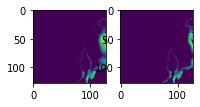

3.1445708


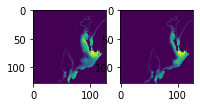

4.179074


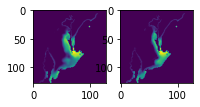

4.210178


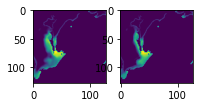

4.14095


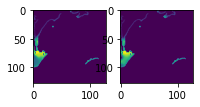

1.1770585


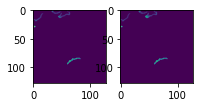

0.19902456


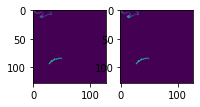

0.16690752


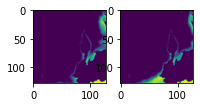

6.496523


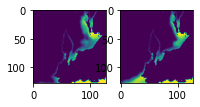

7.535177


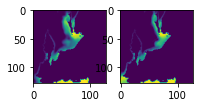

5.772702


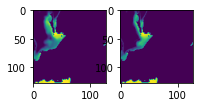

3.9915314


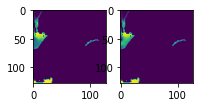

1.0433276


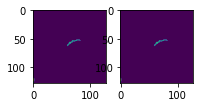

0.036746856


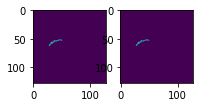

0.017144091


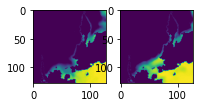

8.781793


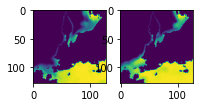

9.726606


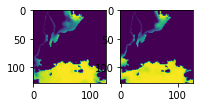

6.5975184


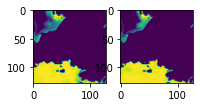

3.7539082


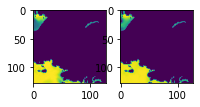

1.6416166


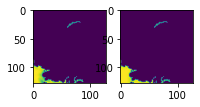

0.5816289


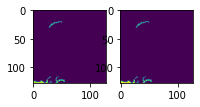

0.09738884


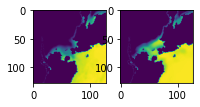

8.213897


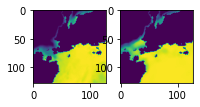

9.111147


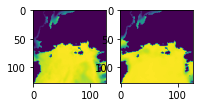

6.9619465


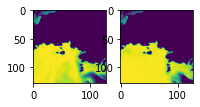

5.258609


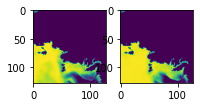

5.135619


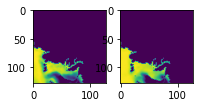

3.9980738


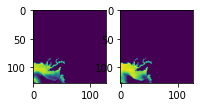

2.5505188


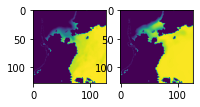

8.050777


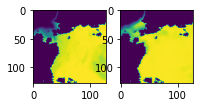

9.495158


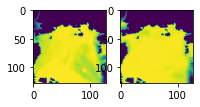

8.826451


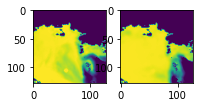

8.125397


In [ ]:
for i in range(36,48):
  plt.subplot(141)
  plt.imshow(y_val_[i,0,:,:,0])
  plt.subplot(142)
  plt.imshow(pred[i,0,:,:,0])
  plt.subplot(143)
  plt.imshow(np.abs(y_val_[i,0,:,:,0] - pred[i,0,:,:,0]))
  plt.show()
  print(np.mean(np.abs(y_val_[i,0,:,:,0] - pred[i,0,:,:,0])))

# **2018년 추론 데이터 전처리**
2015 ~ 2017년까지 5년간 월별 데이터를 학습과 같은 형태로 전처리

In [ ]:
x_test = train_month[:,-1*window_size:,:,:,:1]
x_test = np.swapaxes(x_test , 0, 1)

In [ ]:
x_test_ = []
for m in range(12):
    feature = []
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            x_ = x_test[:, m, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]/250
            feature.append(x_)
    feature = np.array(feature)
    x_test_.append(feature)
x_test_ = np.array(x_test_)

In [ ]:
x_test_.shape

(12, 84, 5, 128, 128, 1)

# **추론**
각 월별 추론하여 저장

In [ ]:
preds = []
for m in tqdm(range(12)):
    pred = model.predict(x_test_set[m])
    pred = np.where(pred>250, 250, pred)
    preds.append(pred)

100%|██████████| 12/12 [01:33<00:00,  7.75s/it]


# **TTS**
추론 결과 중복된 영역의 경우 평균을 이용해 앙상블
stride값이 작을수록 앙상블에 의해 결과가 좋아지나 일정값 이상으로 작아지면 큰 효과가 없고 추론 시간이 기하급수적으로 늘어납니다.

In [ ]:
voting_mask = np.zeros((x_train.shape[-3], x_train.shape[-2]))
ones = np.ones((feature_size, feature_size))

for i in range((x_train.shape[3]-feature_size)//stride+1):
    for j in range((x_train.shape[4]-feature_size)//stride+1):
        voting_mask[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += ones

평균 계산용 마스크

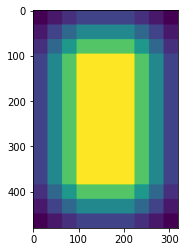

In [ ]:
plt.imshow(voting_mask)

In [ ]:
results = []
for m in range(12):
    pred = np.zeros((x_train.shape[-3], x_train.shape[-2]))
    k = 0
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            pred[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += preds[m][k,-1,:,:,0]
            k+=1
    pred /= voting_mask
    results.append(pred[:448, :304])
results = np.array(results)

# **추론 결과**

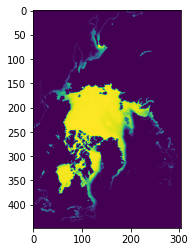

1 



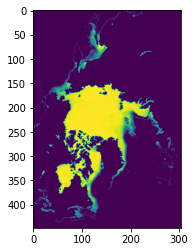

2 



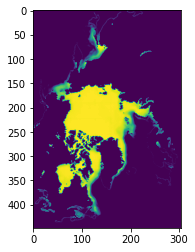

3 



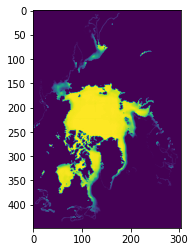

4 



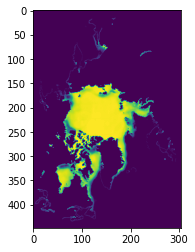

5 



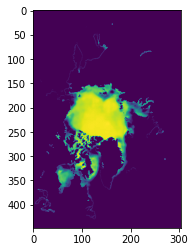

6 



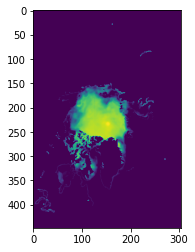

7 



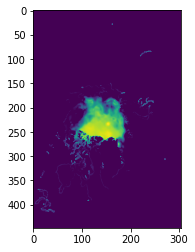

8 



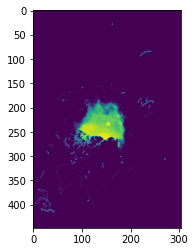

9 



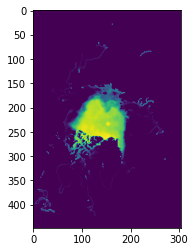

10 



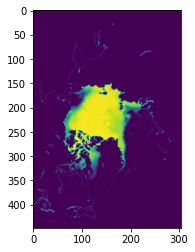

11 



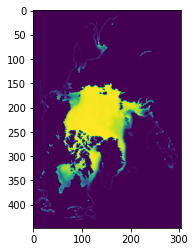

12 



In [ ]:
for m in range(12):
    plt.imshow(results[m])
    plt.show()
    print(m+1, '\n')